In [77]:
# import os
# import shutil

# # Dossier source (où se trouvent tous les dossiers d’origine)
# source_dir = "dataset"
# # Dossier cible avec structure propre
# target_dir = os.path.join(source_dir, "animals")
# os.makedirs(target_dir, exist_ok=True)

# # Parcours des sous-dossiers
# for folder in os.listdir(source_dir):
#     folder_path = os.path.join(source_dir, folder)

#     # On cible les dossiers contenant "resize-300"
#     if os.path.isdir(folder_path) and "resize-300" in folder:
#         animal_name = folder.split("-resize")[0]
#         print(f"📂 Traitement : {animal_name}")

#         # Cas 1 : sous-dossier "resize-300"
#         subfolder_path_1 = os.path.join(folder_path, "resize-300")
#         # Cas 2 : sous-dossier qui a le même nom que le dossier parent
#         subfolder_path_2 = os.path.join(folder_path, folder)

#         # On choisit le bon sous-dossier
#         if os.path.exists(subfolder_path_1):
#             final_path = subfolder_path_1
#         elif os.path.exists(subfolder_path_2):
#             final_path = subfolder_path_2
#         else:
#             print(f"⚠️ Aucun sous-dossier trouvé dans {folder_path}, on passe")
#             continue

#         # Créer le dossier de destination
#         dest_path = os.path.join(target_dir, animal_name)
#         os.makedirs(dest_path, exist_ok=True)

#         # Copier les images
#         for img_file in os.listdir(final_path):
#             src_img_path = os.path.join(final_path, img_file)
#             dest_img_path = os.path.join(dest_path, img_file)
#             shutil.copy2(src_img_path, dest_img_path)

# print("✅ Dataset réorganisé proprement dans : 'dataset/animals'")


In [ ]:
from PIL import Image, UnidentifiedImageError
import os

def clean_broken_images(folder):
    total, removed = 0, 0
    for root, _, files in os.walk(folder):
        for f in files:
            path = os.path.join(root, f)
            total += 1
            try:
                img = Image.open(path)
                img.verify()
            except (UnidentifiedImageError, OSError):
                print(f"🗑️ Suppression : {path}")
                os.remove(path)
                removed += 1
    print(f"✅ Nettoyage terminé : {removed} image(s) supprimée(s) sur {total}")

# Utilisation :
clean_broken_images("dataset/animals")

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.ImageFolder("dataset/animals", transform=transform)

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=8,           # adapte à ta machine
    pin_memory=True,
    persistent_workers=True  # booste sur les longues sessions
)
print(f"✅ {len(dataset)} images dans le dataset")
print(f"✅ {len(dataloader)} batches dans le dataloader")

✅ Nettoyage terminé : 0 image(s) supprimée(s) sur 1723
✅ 1723 images dans le dataset
✅ 14 batches dans le dataloader


In [79]:
import torch

class Diffusion:
    def __init__(self, timesteps=100, beta_start=1e-4, beta_end=0.02, device="cuda"):
        self.timesteps = timesteps
        self.device = device

        self.betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
        self.alphas = 1. - self.betas
        self.alpha_hat = torch.cumprod(self.alphas, dim=0)

    def noise_images(self, x0, t, noise=None):
        if noise is None:
            noise = torch.randn_like(x0)

        sqrt_alpha_hat = self.alpha_hat[t][:, None, None, None].sqrt()
        sqrt_one_minus_alpha_hat = (1 - self.alpha_hat[t])[:, None, None, None].sqrt()
        return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise, noise


In [ ]:
@torch.no_grad()
def save_sample_grid(model, diffusion, class_label, epoch, image_size=64, n=16):
    model.eval()
    device = next(model.parameters()).device

    x = torch.randn(n, 3, image_size, image_size).to(device)
    y = torch.full((n,), class_label, device=device, dtype=torch.long)

    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_tensor, y)

        beta = diffusion.betas[t]
        alpha = diffusion.alphas[t]
        alpha_hat = diffusion.alpha_hat[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_hat).sqrt()) * predicted_noise) + beta.sqrt() * noise

    x = (x.clamp(-1, 1) + 1) / 2

    from torchvision.utils import make_grid
    import matplotlib.pyplot as plt
    import os
    os.makedirs("samples", exist_ok=True)

    grid = make_grid(x, nrow=4).permute(1, 2, 0).cpu()
    plt.figure(figsize=(6, 6))
    plt.imshow(grid)
    plt.axis("off")
    plt.title(f"Échantillons - classe {class_label} - epoch {epoch}")
    plt.savefig(f"samples/sample_epoch{epoch}_class{class_label}.png")
    plt.close()


In [87]:
import torch.nn as nn

class SimpleConditionalUNet(nn.Module):
    def __init__(self, in_channels=3, time_dim=256, num_classes=5):
        super().__init__()

        self.time_embed = nn.Sequential(
            nn.Linear(1, time_dim),
            nn.ReLU(),
            nn.Linear(time_dim, time_dim),
        )

        self.class_embed = nn.Embedding(num_classes, time_dim)

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU(),
            )

        self.conv1 = conv_block(in_channels + 1, 64)
        self.conv2 = conv_block(64, 128)
        self.conv3 = conv_block(128, 64)
        self.out = nn.Conv2d(64, in_channels, 1)

        self.pool = nn.MaxPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")

    def forward(self, x, t, y):
        # Embed time
        t = t.view(-1, 1).float()
        t_emb = self.time_embed(t)

        # Embed class
        y_emb = self.class_embed(y)

        # Fusion (add or concat, ici on add)
        emb = t_emb + y_emb
        emb = emb[:, :, None, None].expand(-1, -1, x.shape[2], x.shape[3])

        # Concat time+class embedding comme canal supplémentaire
        x = torch.cat([x, emb[:, :1]], dim=1)

        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.up(x2))

        return self.out(x3 + x1)


In [82]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

num_classes = len(dataset.classes)
model = SimpleConditionalUNet(num_classes=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
diffusion = Diffusion(timesteps=100, device=device)

epochs = 300

for epoch in range(epochs):
    if (epoch + 1) % 5 == 0:
        label_name = "tiger"  # ou autre classe
        label_idx = dataset.class_to_idx[label_name]
        save_sample_grid(model, diffusion, class_label=label_idx, epoch=epoch + 1)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        t = torch.randint(0, diffusion.timesteps, (images.size(0),), device=device).long()

        noised_images, noise = diffusion.noise_images(images, t)
        predicted_noise = model(noised_images, t, labels)

        loss = F.mse_loss(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

torch.save(model.state_dict(), "ddpm_cond_animals.pth")


Epoch 300/300: 100%|██████████| 14/14 [00:33<00:00,  2.42s/it, loss=0.157]


In [88]:
@torch.no_grad()
def sample_ddpm_conditional(model, diffusion, class_label, n=16, image_size=64):
    model.eval()
    device = next(model.parameters()).device

    x = torch.randn(n, 3, image_size, image_size).to(device)
    y = torch.full((n,), class_label, device=device, dtype=torch.long)

    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_tensor, y)

        beta = diffusion.betas[t]
        alpha = diffusion.alphas[t]
        alpha_hat = diffusion.alpha_hat[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (1 / alpha.sqrt()) * (x - ((1 - alpha) / (1 - alpha_hat).sqrt()) * predicted_noise) + beta.sqrt() * noise

    x = x.clamp(-1, 1)
    x = (x + 1) / 2
    return x



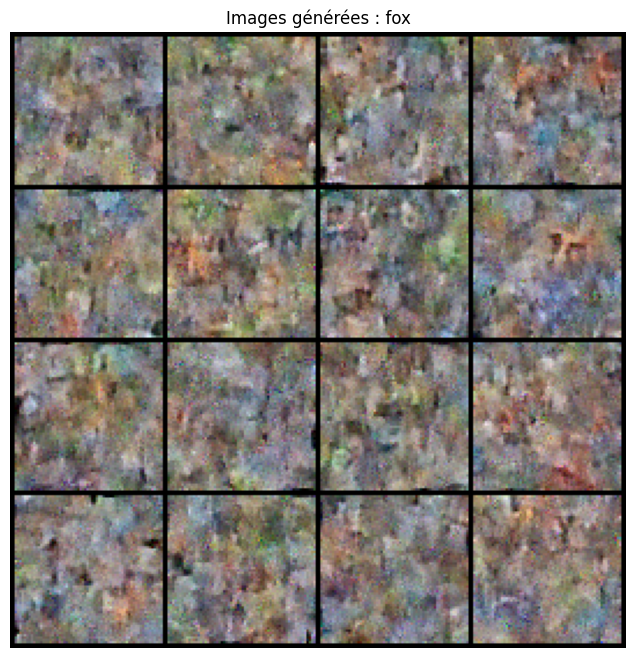

In [84]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
# Recharger le modèle
model.load_state_dict(torch.load("ddpm_cond_animals.pth"))
model.eval()

# Générer des tigres (par ex : class 4)
label_name = "fox"
label_idx = dataset.class_to_idx[label_name]

samples = sample_ddpm_conditional(model, diffusion, class_label=label_idx, n=16)

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title(f"Images générées : {label_name}")
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0).cpu())
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import os

# 🔧 Paramètres
device = "cuda" if torch.cuda.is_available() else "cpu"
start_epoch = 300  # Tu reprends ici
epochs = 100       # Nombre de nouvelles epochs à faire
model_path = "ddpm_cond_animals_last.pth"
save_dir = "models"

# 📁 Crée le dossier de sauvegarde s'il n'existe pas
os.makedirs(save_dir, exist_ok=True)

# Instanciation du modèle
model = SimpleConditionalUNet(num_classes=len(dataset.classes)).to(device)

# Chargement du modèle précédent
model.load_state_dict(torch.load(model_path))

# Optimiseur
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 🔁 Diffusion
diffusion = Diffusion(timesteps=100, device=device)

# 🔥 Reprise de l'entraînement
for epoch in range(start_epoch, start_epoch + epochs + 1):
    # Génération d’échantillons toutes les 5 époques
    if epoch % 5 == 0:
        label_name = "tiger"  # Change la classe si tu veux
        label_idx = dataset.class_to_idx[label_name]
        save_sample_grid(model, diffusion, class_label=label_idx, epoch=epoch)

    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{start_epoch + epochs}")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        t = torch.randint(0, diffusion.timesteps, (images.size(0),), device=device).long()

        noised_images, noise = diffusion.noise_images(images, t)
        predicted_noise = model(noised_images, t, labels)

        loss = F.mse_loss(predicted_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

    # Sauvegarde toutes les 25 epochs dans models/
    if epoch % 25 == 0:
        model_save_path = os.path.join(save_dir, f"ddpm_epoch_{epoch}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"✅ Modèle sauvegardé : {model_save_path}")


Epoch 300/400: 100%|██████████| 14/14 [00:34<00:00,  2.49s/it, loss=0.183]


✅ Modèle sauvegardé : models\ddpm_epoch_300.pth


Epoch 325/400: 100%|██████████| 14/14 [00:22<00:00,  1.57s/it, loss=0.134]


✅ Modèle sauvegardé : models\ddpm_epoch_325.pth


Epoch 350/400: 100%|██████████| 14/14 [00:22<00:00,  1.60s/it, loss=0.123]


✅ Modèle sauvegardé : models\ddpm_epoch_350.pth


Epoch 375/400: 100%|██████████| 14/14 [00:25<00:00,  1.84s/it, loss=0.128]


✅ Modèle sauvegardé : models\ddpm_epoch_375.pth


Epoch 400/400: 100%|██████████| 14/14 [00:21<00:00,  1.56s/it, loss=0.155]

✅ Modèle sauvegardé : models\ddpm_epoch_400.pth


In [95]:
@torch.no_grad()
def generate_samples(model, diffusion, class_label, n=16, image_size=64):
    model.eval()
    device = next(model.parameters()).device

    x = torch.randn(n, 3, image_size, image_size).to(device)

    for t in reversed(range(diffusion.timesteps)):
        t_tensor = torch.full((n,), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_tensor, torch.full((n,), class_label, device=device))

        alpha_t = diffusion.alphas[t]
        alpha_hat_t = diffusion.alpha_hat[t]
        beta_t = diffusion.betas[t]

        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)

        x = (
            1 / alpha_t.sqrt()
        ) * (x - ((1 - alpha_t) / (1 - alpha_hat_t).sqrt()) * predicted_noise) + beta_t.sqrt() * noise

    x = (x.clamp(-1, 1) + 1) / 2  # Ramène dans [0, 1] pour affichage
    return x


🔍 Classe 0: cheetah


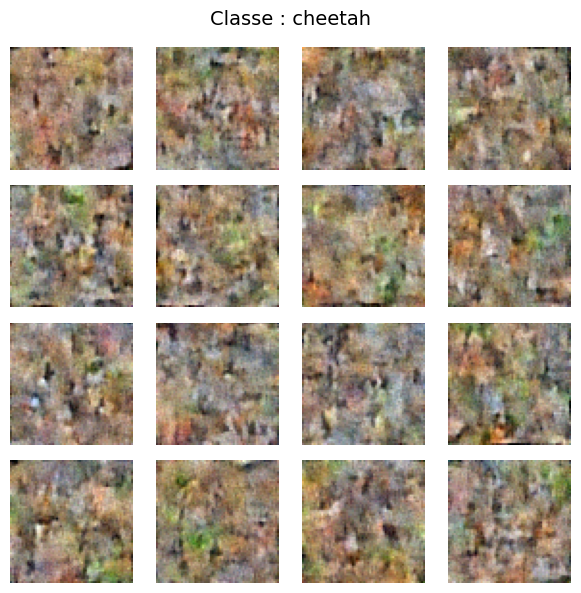

🔍 Classe 1: fox


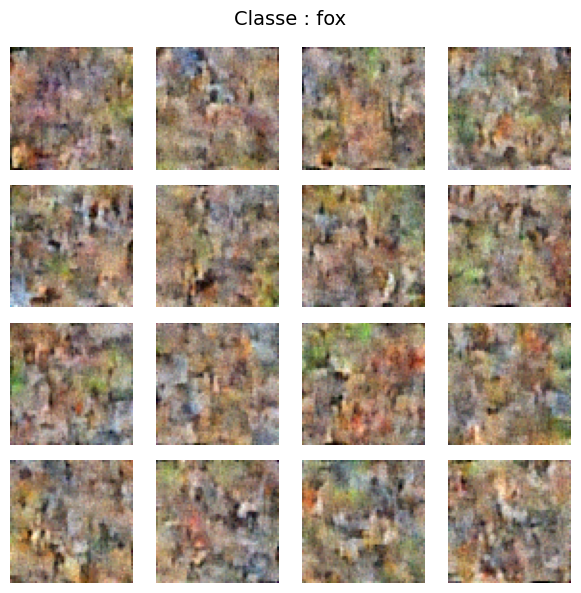

🔍 Classe 2: hyena


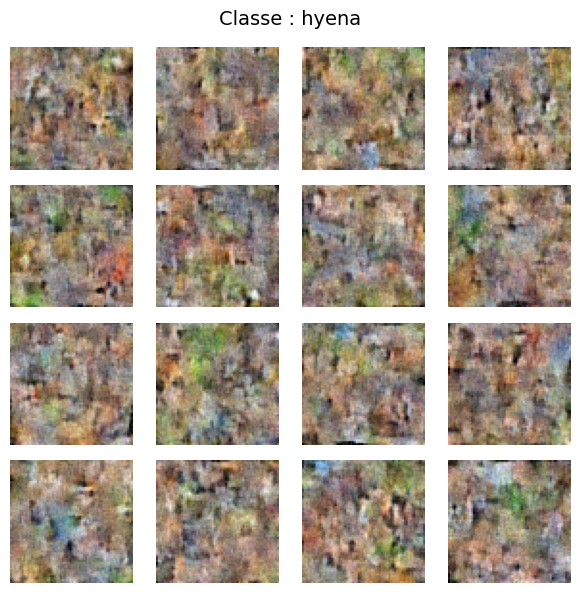

🔍 Classe 3: lion


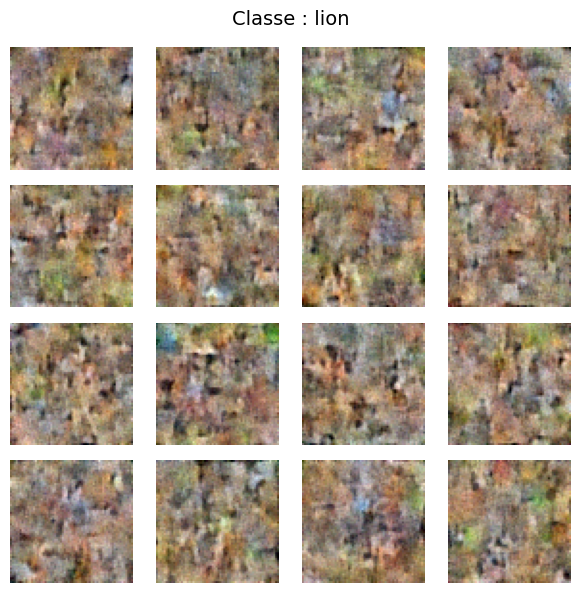

🔍 Classe 4: tiger


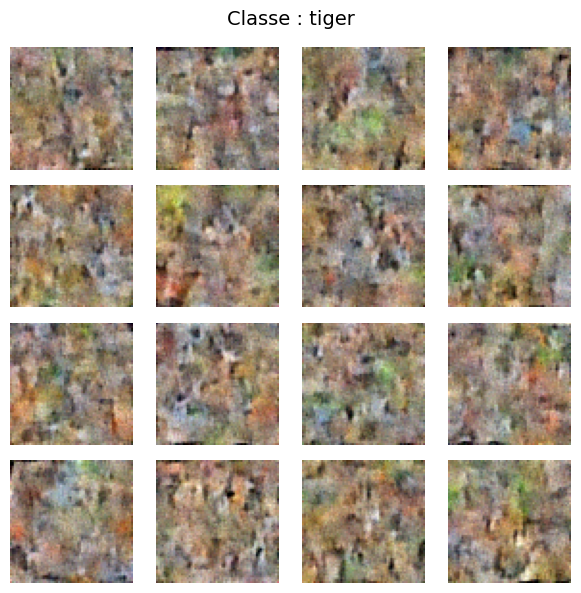

🔍 Classe 5: wolf


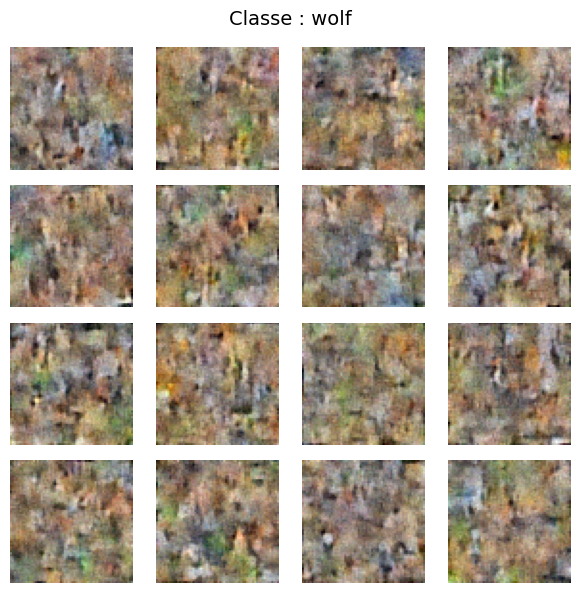

In [96]:
import matplotlib.pyplot as plt

classes = dataset.classes
n_images = 16

for idx, class_name in enumerate(classes):
    print(f"🔍 Classe {idx}: {class_name}")
    samples = generate_samples(model, diffusion, class_label=idx, n=n_images).cpu()

    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(samples[i].permute(1, 2, 0).clamp(0, 1).numpy())
        ax.axis('off')
    plt.suptitle(f"Classe : {class_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
